In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GroupShuffleSplit

from scipy import sparse

%matplotlib inline

In [2]:
PATH_TO_DATA = './../data/kaggle_receipts/'

## load data train

In [3]:
train_df = pd.read_csv(PATH_TO_DATA + 'train.csv')
train_checks_df = pd.read_csv(PATH_TO_DATA + 'train_checks.csv')

train_full_df = pd.merge(train_df, train_checks_df, on='check_id')

train_full_df['name'].fillna('', inplace=True)
train_full_df['shop_name'].fillna('', inplace=True)

## load data test

In [4]:
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')
test_checks_df = pd.read_csv(PATH_TO_DATA + 'test_checks.csv')

test_full_df = pd.merge(test_df, test_checks_df, on='check_id')

test_full_df['name'].fillna('', inplace=True)
test_full_df['shop_name'].fillna('', inplace=True)

## features engineering

In [5]:
features_train = dict()
features_test = dict()

### name

In [6]:
def contain_digits(name):
    digits_list = [str(i) for i in range(10)]
    for symbol in name:
        if symbol in digits_list:
            return True
    return False

def name_processing(name):
    result = name
    
    result = result.lower()
    result = ' '.join([token for token in result.split() if (not contain_digits(token)) and (len(token) > 2)])
    result = result.strip()
    
    return result

In [7]:
train_name = train_full_df['name'].apply(name_processing)
test_name = test_full_df['name'].apply(name_processing)

#### count vectorizer

In [8]:
#count_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000)
count_vectorizer = CountVectorizer()

count_vectorizer.fit(train_name)

train_name_cvect = count_vectorizer.transform(train_name)
test_name_cvect = count_vectorizer.transform(test_name)

print(train_name_cvect.shape, test_name_cvect.shape)

(13682, 10713) (3000, 10713)


In [9]:
features_train['name_cvect'] = train_name_cvect
features_test['name_cvect'] = test_name_cvect

### price

In [10]:
PERCENTILE_VALUE = 95

category_percentiles = {cat: np.percentile(train_full_df[train_full_df['category'] == cat]['price'], 
                                           PERCENTILE_VALUE) 
                        for cat in pd.unique(train_full_df['category'])}

def cut_percentile(row):
    return min(row['price'], category_percentiles[row['category']])

In [11]:
train_price = train_full_df.apply(cut_percentile, axis=1)

#test_price = test_full_df.apply(cut_percentile, axis=1)
test_price = test_full_df['price']

In [12]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
train_price = min_max_scaler.fit_transform(train_price.values.reshape(-1, 1))
train_price = pd.DataFrame(train_price, columns=['percentile_filtered_price'])

test_price = min_max_scaler.fit_transform(test_price.values.reshape(-1, 1))
test_price = pd.DataFrame(test_price, columns=['percentile_filtered_price'])

In [14]:
features_train['price'] = train_price
features_test['price'] = test_price

### shop_name

In [15]:
train_shop_name = train_full_df['shop_name']
test_shop_name = test_full_df['shop_name']

In [16]:
na_string = 'unknown'

print('train and test contains na_string:', na_string in train_shop_name.values, na_string in test_shop_name.values)
print('unique nameis in train and test:', len(train_shop_name.unique()), len(test_shop_name.unique()))
print('intersection of train and test:', len(set(train_shop_name.values) & set(test_shop_name.values)))

train and test contains na_string: False False
unique nameis in train and test: 525 129
intersection of train and test: 74


In [17]:
def analyse_shop_name(name):
    if name in train_shop_name.values:
        return name
    else:
        return na_string

In [18]:
train_shop_name_with_na = train_shop_name.append(pd.Series([na_string]), ignore_index=True)
test_shop_name_with_na = test_shop_name.apply(analyse_shop_name)

In [19]:
print('unique nameis in train and test after processing:', 
      len(train_shop_name_with_na.unique()), 
      len(test_shop_name_with_na.unique()))

unique nameis in train and test after processing: 526 75


In [20]:
shop_name_labeler = LabelEncoder()

In [21]:
%%time

shop_name_labeler.fit(train_shop_name_with_na)

train_shop_name_le = pd.DataFrame(shop_name_labeler.transform(train_shop_name_with_na), columns=['shop_name'])
test_shop_name_le = pd.DataFrame(shop_name_labeler.transform(test_shop_name_with_na), columns=['shop_name'])

Wall time: 16 ms


In [22]:
shop_name_ohe = OneHotEncoder()

In [23]:
%%time

shop_name_ohe.fit(train_shop_name_le)

# remember to remove na_string from train!
train_shop_name_ohe = shop_name_ohe.transform(train_shop_name_le.iloc[:-1, :])
test_shop_name_ohe = shop_name_ohe.transform(test_shop_name_le)

Wall time: 7 ms


In [24]:
print('train_shop_name_ohe:', train_shop_name_ohe.shape)
print('test_shop_name_ohe:', test_shop_name_ohe.shape)

train_shop_name_ohe: (13682, 526)
test_shop_name_ohe: (3000, 526)


In [25]:
features_train['shop_name'] = train_shop_name_ohe
features_test['shop_name'] = test_shop_name_ohe

### datetime

In [26]:
one_hot_encoder = OneHotEncoder()

In [27]:
train_datetime = train_full_df['datetime'].apply(pd.to_datetime)
test_datetime = test_full_df['datetime'].apply(pd.to_datetime)

In [28]:
train_hour = train_datetime.apply(lambda dt: dt.hour).values.reshape(-1, 1)
test_hour = test_datetime.apply(lambda dt: dt.hour).values.reshape(-1, 1)

one_hot_encoder.fit(train_hour)

train_hour = one_hot_encoder.transform(train_hour)
test_hour = one_hot_encoder.transform(test_hour)

In [29]:
features_train['hour'] = train_hour
features_test['hour'] = test_hour

In [30]:
train_dayofweek = train_datetime.apply(lambda dt: dt.dayofweek).values.reshape(-1, 1)
test_dayofweek = test_datetime.apply(lambda dt: dt.dayofweek).values.reshape(-1, 1)

one_hot_encoder.fit(train_dayofweek)

train_dayofweek = one_hot_encoder.transform(train_dayofweek)
test_dayofweek = one_hot_encoder.transform(test_dayofweek)

In [31]:
features_train['dayofweek'] = train_dayofweek
features_test['dayofweek'] = test_dayofweek

### category

In [32]:
category_labeler = LabelEncoder()

In [33]:
%%time

train_category = category_labeler.fit_transform(train_full_df['category'])
#train_category = pd.DataFrame(train_category, columns=['category'])

Wall time: 12 ms


In [34]:
np.unique(train_category)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [35]:
y_train = train_category

## join features

In [36]:
for name, feat in features_train.items():
    print('{} : {}, {}'.format(name, type(feat), feat.shape))

name_cvect : <class 'scipy.sparse.csr.csr_matrix'>, (13682, 10713)
price : <class 'pandas.core.frame.DataFrame'>, (13682, 1)
shop_name : <class 'scipy.sparse.csr.csr_matrix'>, (13682, 526)
hour : <class 'scipy.sparse.csr.csr_matrix'>, (13682, 23)
dayofweek : <class 'scipy.sparse.csr.csr_matrix'>, (13682, 7)


In [37]:
for name, feat in features_test.items():
    print('{} : {}, {}'.format(name, type(feat), feat.shape))

name_cvect : <class 'scipy.sparse.csr.csr_matrix'>, (3000, 10713)
price : <class 'pandas.core.frame.DataFrame'>, (3000, 1)
shop_name : <class 'scipy.sparse.csr.csr_matrix'>, (3000, 526)
hour : <class 'scipy.sparse.csr.csr_matrix'>, (3000, 23)
dayofweek : <class 'scipy.sparse.csr.csr_matrix'>, (3000, 7)


In [38]:
full_use_list = [
    [
        'name_cvect'
    ],
    [
        'price', 
        'shop_name', 
        'hour', 
        'dayofweek'
    ]
]

selected_features_train = [[feat for (name, feat) in features_train.items() if name in use_list] for use_list in full_use_list]
selected_features_test = [[feat for (name, feat) in features_test.items() if name in use_list] for use_list in full_use_list]

X_train_full = [sparse.csr_matrix(sparse.hstack(features)) for features in selected_features_train]
X_test_full = [sparse.csr_matrix(sparse.hstack(features)) for features in selected_features_test]

y_train_full = y_train

print('X_train_full:', X_train_full[0].shape, X_train_full[1].shape)
print('X_test_full:', X_test_full[0].shape, X_test_full[1].shape)
print('y_train_full:', y_train_full.shape)

X_train_full: (13682, 10713) (13682, 557)
X_test_full: (3000, 10713) (3000, 557)
y_train_full: (13682,)


## manual param search

In [39]:
C_range = np.logspace(-2, 4, 25)

for idx, C in enumerate(C_range):
    print('{} -> {}'.format(idx, C))

0 -> 0.01
1 -> 0.01778279410038923
2 -> 0.03162277660168379
3 -> 0.05623413251903491
4 -> 0.1
5 -> 0.1778279410038923
6 -> 0.31622776601683794
7 -> 0.5623413251903491
8 -> 1.0
9 -> 1.7782794100389228
10 -> 3.1622776601683795
11 -> 5.623413251903491
12 -> 10.0
13 -> 17.78279410038923
14 -> 31.622776601683793
15 -> 56.23413251903491
16 -> 100.0
17 -> 177.82794100389228
18 -> 316.22776601683796
19 -> 562.341325190349
20 -> 1000.0
21 -> 1778.2794100389228
22 -> 3162.2776601683795
23 -> 5623.413251903491
24 -> 10000.0


In [41]:
gss = GroupShuffleSplit(n_splits=5, random_state=0)
gss_splits = [list(gss.split(X, y_train_full, train_full_df['check_id'].values)) for X in X_train_full]

In [42]:
total_lrs = []
total_cv_scores = []

In [43]:
for idx in range(2):
    
    lrs = []
    cv_scores = []
    
    for C in tqdm_notebook(C_range):

        cur_lr = LogisticRegression(C=C, random_state=14)

        cv_score = cross_val_score(cur_lr, 
                                   X_train_full[idx], 
                                   y_train_full, 
                                   scoring='neg_log_loss', 
                                   cv=gss_splits[idx], 
                                   n_jobs=-1)

        lrs.append(cur_lr)
        cv_scores.append(-1 * cv_score.mean())
    
    total_lrs.append(lrs)
    total_cv_scores.append(cv_scores)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

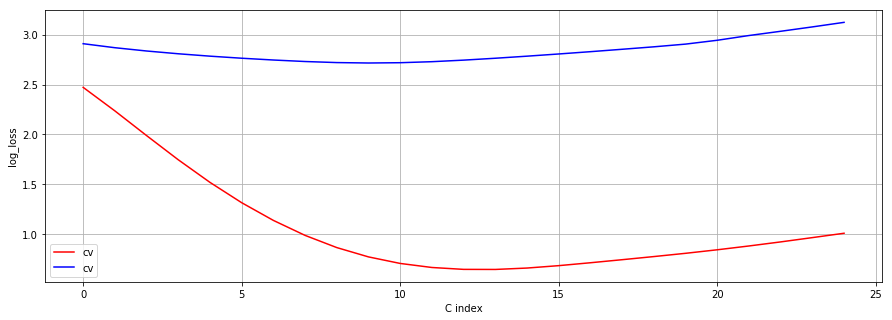

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(C_range)), total_cv_scores[0], color='red', label='cv')
plt.plot(range(len(C_range)), total_cv_scores[1], color='blue', label='cv')

#plt.ylim(0.94, 1.01)
#plt.xlim(18, 22)
plt.xlabel("C index")
plt.ylabel("log_loss")
plt.legend()
plt.grid()
plt.show()

In [46]:
for idx in range(2):
    print('estimator', idx)
    print('best cv score:', np.min(total_cv_scores[idx]))
    print('best C:', C_range[np.argmin(total_cv_scores[idx])])
    print('best C index:', np.argmin(total_cv_scores[idx]))

ms_best_estimators = [lrs[np.argmin(total_cv_scores[idx])] for idx in range(2)] 

estimator 0
best cv score: 0.648467317835492
best C: 17.78279410038923
best C index: 13
estimator 1
best cv score: 2.715785430911935
best C: 1.7782794100389228
best C index: 9


## make submission

In [47]:
best_estimators = ms_best_estimators

In [50]:
%%time

for idx in range(2):
    best_estimators[idx].fit(X_train_full[idx], y_train_full)

Wall time: 1.69 s


In [51]:
predictions = (0.5 * best_estimators[0].predict_proba(X_test_full[0]) + 
               0.5 * best_estimators[1].predict_proba(X_test_full[1]))

In [52]:
predictions_df = test_df[['id']]

for idx, category in enumerate(category_labeler.classes_):
    predictions_df = pd.concat([predictions_df, pd.Series(predictions[:, idx], name=category)], axis=1)

In [53]:
timestamp = datetime.now().strftime('%m%d_%H%M')
predictions_df.to_csv('./submissions/submission_{}.csv'.format(timestamp), encoding='utf-8', index=False)